# MCMC事後分布の形状分析と正規分布近似の妥当性確認

このnotebookでは、階層的ベイズロジスティック回帰モデルのMCMC事後分布の形状を詳しく分析し、
正規分布近似が適切かどうかを確認します。

## 分析項目
1. **周辺分布の形状**: 各パラメータの周辺分布を可視化
2. **対称性の確認**: 分布の対称性を定量的に評価
3. **多峰性の検出**: 分布が多峰性を持つかどうかを確認
4. **尾部の重さ**: 正規分布と比較して尾部が重いかどうかを評価
5. **パラメータ間の依存関係**: 相関構造と非線形依存関係の分析
6. **正規分布近似の誤差**: 正規分布近似による誤差の定量化

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import norm, multivariate_normal, ks_2samp, shapiro, jarque_bera
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import pickle
import warnings
warnings.filterwarnings('ignore')

# 日本語フォントの設定
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['axes.unicode_minus'] = False

# プロットのスタイル設定
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("必要なライブラリをインポートしました")

必要なライブラリをインポートしました


In [2]:
# MCMC結果の読み込み
def load_mcmc_results(filename="mcmc_results_2000_1000_4_42.pkl"):
    """MCMC結果を読み込む"""
    try:
        with open(filename, 'rb') as f:
            results = pickle.load(f)
        
        mcmc_samples = results['mcmc_samples']
        true_mu = results['true_mu']
        true_A = results['true_A']
        
        print(f"MCMCサンプル形状: {mcmc_samples.shape}")
        print(f"パラメータ数: {mcmc_samples.shape[1]}")
        print(f"サンプル数: {mcmc_samples.shape[0]}")
        
        return mcmc_samples, true_mu, true_A, results
    except FileNotFoundError:
        print(f"ファイル {filename} が見つかりません")
        return None, None, None, None

# データを読み込み
mcmc_samples, true_mu, true_A, mcmc_results = load_mcmc_results()

if mcmc_samples is None:
    print("MCMC結果が見つからないため、分析を続行できません")
    print("まず run_mcmc.py を実行してMCMC結果を生成してください")
else:
    print("MCMC結果の読み込みが完了しました")

MCMCサンプル形状: (8000, 55)
パラメータ数: 55
サンプル数: 8000
MCMC結果の読み込みが完了しました


## 1. 基本的な統計量と分布の概要

In [3]:
def analyze_basic_statistics(samples):
    """基本的な統計量を計算"""
    n_params = samples.shape[1]
    
    # 基本統計量
    means = np.mean(samples, axis=0)
    stds = np.std(samples, axis=0)
    medians = np.median(samples, axis=0)
    
    # 歪度と尖度
    skewness = stats.skew(samples, axis=0)
    kurtosis = stats.kurtosis(samples, axis=0)
    
    # 正規性検定
    shapiro_results = []
    jarque_bera_results = []
    
    for i in range(n_params):
        shapiro_stat, shapiro_p = shapiro(samples[:, i])
        shapiro_results.append((shapiro_stat, shapiro_p))
        
        jb_stat, jb_p = jarque_bera(samples[:, i])
        jarque_bera_results.append((jb_stat, jb_p))
    
    # 結果をDataFrameにまとめる
    param_names = [f'beta_{i}' for i in range(n_params-1)] + ['tau']
    
    stats_df = pd.DataFrame({
        'Parameter': param_names,
        'Mean': means,
        'Std': stds,
        'Median': medians,
        'Skewness': skewness,
        'Kurtosis': kurtosis,
        'Shapiro_Stat': [r[0] for r in shapiro_results],
        'Shapiro_p': [r[1] for r in shapiro_results],
        'JB_Stat': [r[0] for r in jarque_bera_results],
        'JB_p': [r[1] for r in jarque_bera_results]
    })
    
    return stats_df

# 基本統計量を計算
if mcmc_samples is not None:
    stats_df = analyze_basic_statistics(mcmc_samples)
    print("基本統計量:")
    display(stats_df.round(4))
    
    # 正規性の要約
    print("\n正規性検定の結果:")
    print(f"Shapiro-Wilk検定で正規分布と有意に異なるパラメータ数: {np.sum(stats_df['Shapiro_p'] < 0.05)}/{len(stats_df)}")
    print(f"Jarque-Bera検定で正規分布と有意に異なるパラメータ数: {np.sum(stats_df['JB_p'] < 0.05)}/{len(stats_df)}")

基本統計量:


Parameter     Mean     Std   Median  Skewness  Kurtosis  Shapiro_Stat  \
0     beta_0 -10.9140  0.4404 -10.9166   -0.0005    0.0469        0.9998   
1     beta_1  -0.1026  0.1208  -0.1011   -0.0090    0.0013        0.9998   
2     beta_2   0.9070  0.4259   0.9030    0.0451    0.0534        0.9996   
3     beta_3   2.1759  0.2482   2.1777   -0.0174    0.0063        0.9998   
4     beta_4   0.1651  0.4854   0.1623   -0.0132   -0.0038        0.9998   
5     beta_5   0.6749  0.1610   0.6763    0.0063   -0.0343        0.9999   
6     beta_6   0.2443  1.2821   0.2301    0.0052    0.1248        0.9996   
7     beta_7   5.7992  1.2087   5.7984    0.0188    0.0705        0.9997   
8     beta_8  -0.3733  1.0796  -0.3889    0.0006    0.1516        0.9996   
9     beta_9   0.0932  0.1733   0.0934   -0.0064    0.0087        0.9999   
10   beta_10  -0.3535  0.8948  -0.3487   -0.0296    0.0341        0.9998   
11   beta_11   0.2194  0.9034   0.2241   -0.0232    0.0296        0.9999   
12   beta_12  -0.3529  0.8940  -0.3482   -0.0242    0.0574        0.9998   
13   beta_13  -5.1052  0.9131  -5.0969   -0.0314    0.0766        0.9998   
14   beta_14  -3.8771  1.4872  -3.7198   -0.6852    0.8996        0.9757   
15   beta_15  -3.7494  0.5561  -3.7424   -0.0646   -0.0728        0.9995   
16   beta_16  -1.7329  0.5377  -1.7283   -0.0262   -0.0692        0.9998   
17   beta_17  -2.6423  0.4738  -2.6400    0.0073   -0.0331        0.9999   
18   beta_18  -3.3658  1.5240  -3.1996   -0.6635    0.6435        0.9760   
19   beta_19  -0.1265  0.6009  -0.1220   -0.0103   -0.0702        0.9997   
20   beta_20   2.4416  1.7431   2.2901    0.5525    0.5794        0.9837   
21   beta_21   0.2893  1.0061   0.2635    0.1000    0.2663        0.9987   
22   beta_22  -0.2158  0.8205  -0.2512    0.1763    0.1267        0.9981   
23   beta_23  -0.2828  0.4467  -0.2863   -0.0055   -0.0683        0.9997   
24   beta_24   0.5409  0.4675   0.5398    0.0106   -0.0640        0.9998   
25   beta_25   2.1146  0.4675   2.1147    0.0066   -0.0050        0.9999   
26   beta_26   0.8418  0.4544   0.8366    0.0211   -0.0957        0.9997   
27   beta_27  -4.3881  1.4708  -4.2344   -0.6244    0.8733        0.9799   
28   beta_28   0.0029  2.6229  -0.0297    0.0120    0.1567        0.9995   
29   beta_29   0.3116  0.5617   0.3069    0.0007   -0.0421        0.9998   
30   beta_30  -2.0208  0.6329  -2.0010   -0.1195   -0.0263        0.9990   
31   beta_31   0.7332  0.8591   0.7035    0.3196    0.3438        0.9943   
32   beta_32   0.4164  0.5335   0.4159   -0.0360   -0.0626        0.9997   
33   beta_33   0.4475  0.4641   0.4468   -0.0033   -0.0082        0.9998   
34   beta_34  -0.5765  0.9002  -0.5308   -0.2643    0.1783        0.9959   
35   beta_35  -0.1923  0.4468  -0.1930    0.0221   -0.1413        0.9996   
36   beta_36   0.2833  0.4342   0.2778    0.0385   -0.1400        0.9996   
37   beta_37   1.0133  0.4442   1.0101    0.0254   -0.0457        0.9997   
38   beta_38   3.5446  1.5029   3.4128    0.5169    0.3917        0.9851   
39   beta_39   1.9277  0.7314   1.8995    0.2567    0.0703        0.9961   
40   beta_40  -0.3473  0.7848  -0.3385   -0.1569    0.1277        0.9984   
41   beta_41   3.6604  1.4717   3.4947    0.7045    0.8300        0.9739   
42   beta_42   1.0963  0.4350   1.0898    0.0169   -0.1034        0.9996   
43   beta_43   1.0284  0.4456   1.0307    0.0094   -0.1088        0.9997   
44   beta_44   1.0166  0.4415   1.0052    0.0348   -0.0861        0.9995   
45   beta_45   1.3437  0.4348   1.3363    0.0285   -0.0925        0.9996   
46   beta_46   1.0321  0.4376   1.0254    0.0102   -0.0810        0.9996   
47   beta_47   1.8370  0.6975   1.8262    0.0769    0.1474        0.9994   
48   beta_48  -2.7611  1.6676  -2.5728   -0.7007    0.8199        0.9741   
49   beta_49  -1.6336  1.9350  -1.4957   -0.4396    0.3374        0.9891   
50   beta_50  -1.6426  1.9212  -1.4445   -0.5574    0.2825        0.9816   
51   beta_51  -0.5290  0.4977  -0.5374    0.0123   


正規性検定の結果:
Shapiro-Wilk検定で正規分布と有意に異なるパラメータ数: 23/55
Jarque-Bera検定で正規分布と有意に異なるパラメータ数: 25/55


## 2. 周辺分布の可視化と正規分布との比較

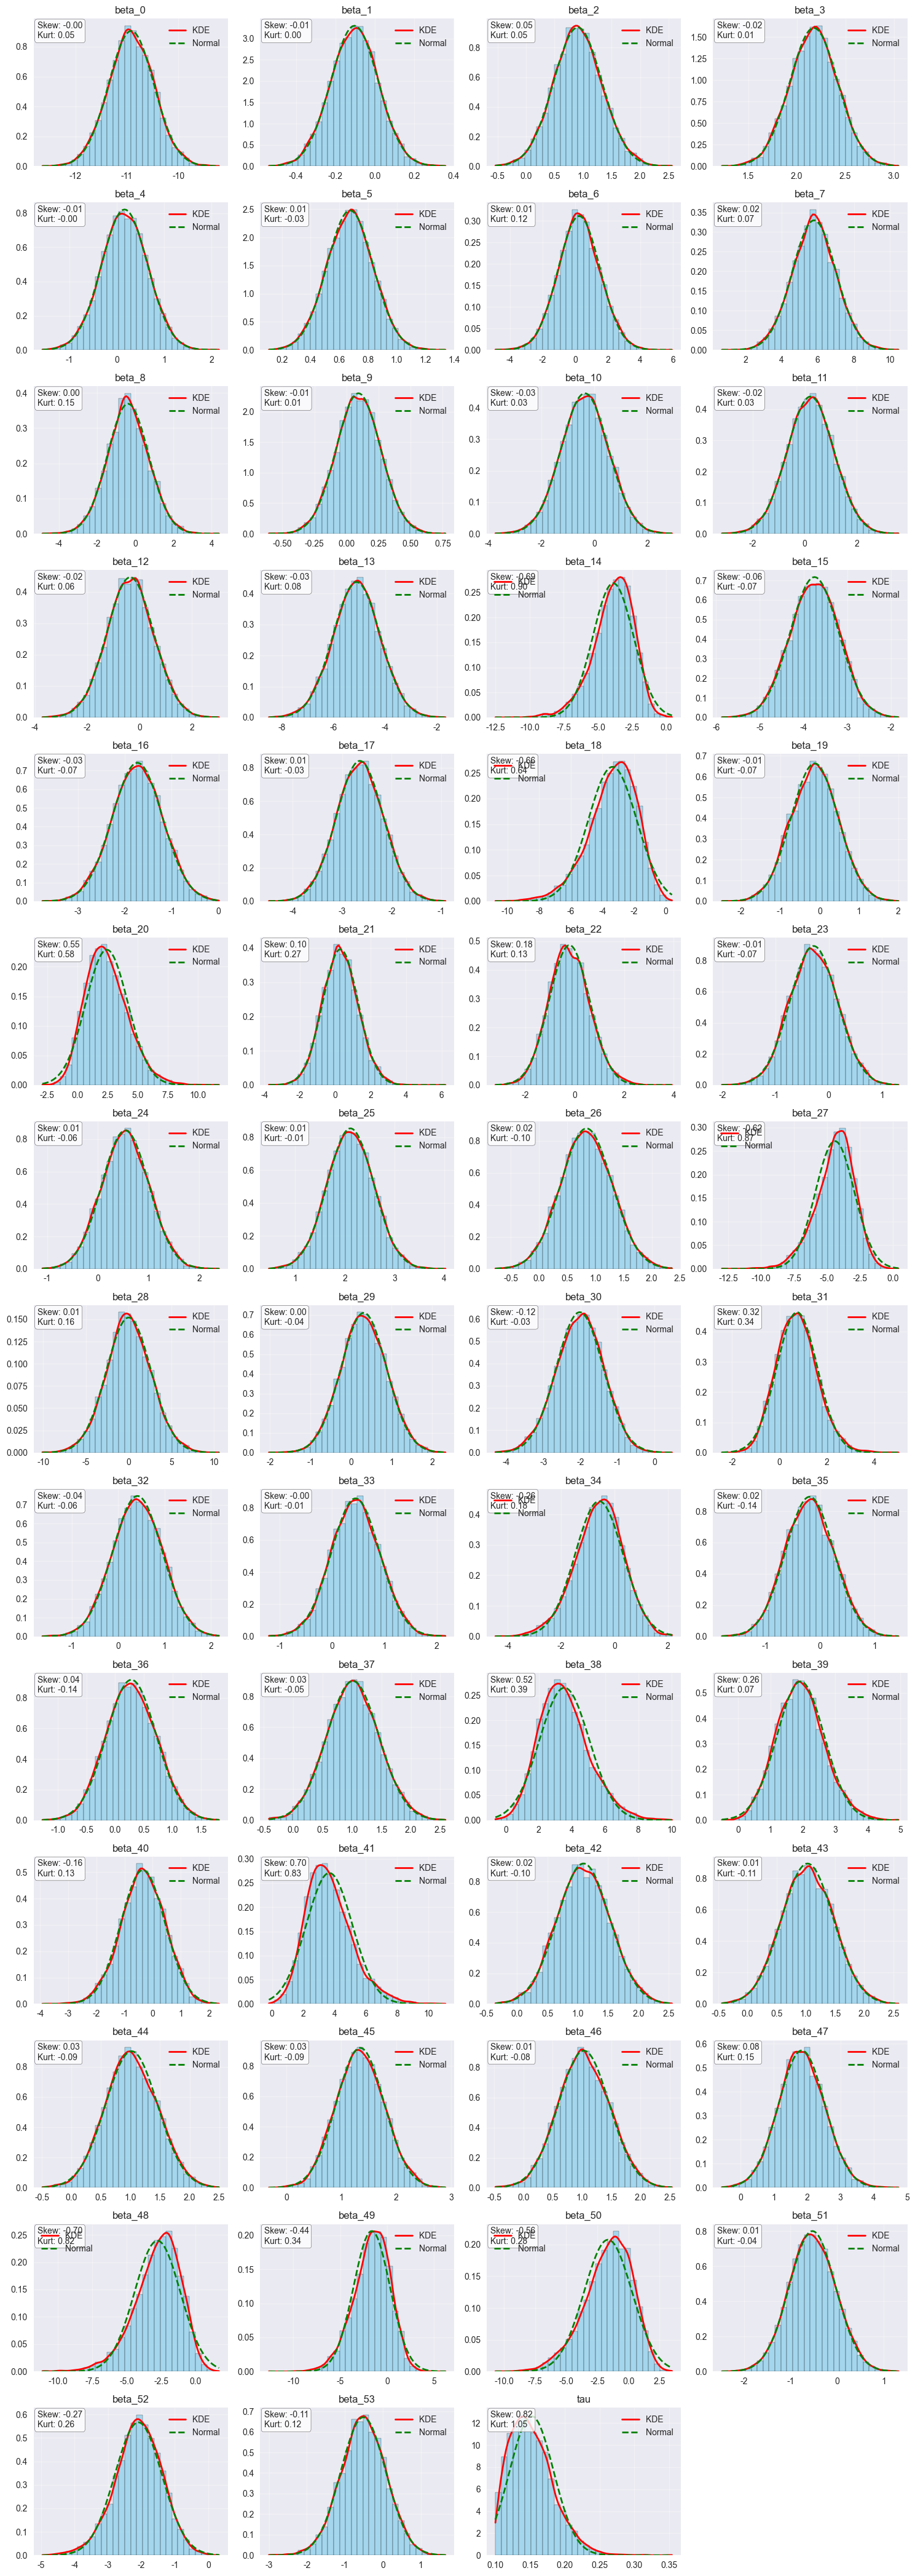

In [4]:
def plot_marginal_distributions(samples, n_cols=4):
    """各パラメータの周辺分布を可視化"""
    n_params = samples.shape[1]
    n_rows = (n_params + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 3*n_rows))
    if n_rows == 1:
        axes = axes.reshape(1, -1)
    
    param_names = [f'beta_{i}' for i in range(n_params-1)] + ['tau']
    
    for i in range(n_params):
        row = i // n_cols
        col = i % n_cols
        ax = axes[row, col]
        
        # ヒストグラム
        ax.hist(samples[:, i], bins=30, density=True, alpha=0.7, color='skyblue', edgecolor='black')
        
        # カーネル密度推定
        kde = stats.gaussian_kde(samples[:, i])
        x_range = np.linspace(samples[:, i].min(), samples[:, i].max(), 100)
        ax.plot(x_range, kde(x_range), 'r-', linewidth=2, label='KDE')
        
        # 正規分布
        mu, std = np.mean(samples[:, i]), np.std(samples[:, i])
        normal_pdf = norm.pdf(x_range, mu, std)
        ax.plot(x_range, normal_pdf, 'g--', linewidth=2, label='Normal')
        
        # 統計量の表示
        skew = stats.skew(samples[:, i])
        kurt = stats.kurtosis(samples[:, i])
        ax.text(0.02, 0.98, f'Skew: {skew:.2f}\nKurt: {kurt:.2f}', 
                transform=ax.transAxes, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
        
        ax.set_title(f'{param_names[i]}')
        ax.legend()
        ax.grid(True, alpha=0.3)
    
    # 余分なサブプロットを非表示
    for i in range(n_params, n_rows * n_cols):
        row = i // n_cols
        col = i % n_cols
        axes[row, col].set_visible(False)
    
    plt.tight_layout()
    plt.show()

# 周辺分布をプロット
if mcmc_samples is not None:
    plot_marginal_distributions(mcmc_samples)

## 3. 対称性と多峰性の詳細分析

In [5]:
def analyze_symmetry_and_modality(samples):
    """対称性と多峰性を分析"""
    n_params = samples.shape[1]
    param_names = [f'beta_{i}' for i in range(n_params-1)] + ['tau']
    
    results = []
    
    for i in range(n_params):
        data = samples[:, i]
        
        # 対称性の指標
        mean_val = np.mean(data)
        median_val = np.median(data)
        skewness = stats.skew(data)
        
        # 平均と中央値の差（対称性の指標）
        mean_median_diff = abs(mean_val - median_val) / np.std(data)
        
        # 多峰性の検出（簡易版）
        # ヒストグラムのピーク数を数える
        hist, bins = np.histogram(data, bins=30)
        peaks = []
        for j in range(1, len(hist)-1):
            if hist[j] > hist[j-1] and hist[j] > hist[j+1] and hist[j] > np.max(hist) * 0.1:
                peaks.append(bins[j])
        n_peaks = len(peaks)
        
        # より高度な多峰性検出（Silverman's test）
        try:
            from scipy.stats import gaussian_kde
            kde = gaussian_kde(data)
            x_range = np.linspace(data.min(), data.max(), 200)
            kde_vals = kde(x_range)
            
            # 局所最大値の検出
            local_maxima = []
            for j in range(1, len(kde_vals)-1):
                if kde_vals[j] > kde_vals[j-1] and kde_vals[j] > kde_vals[j+1]:
                    local_maxima.append(x_range[j])
            
            # 有意なピークのみをカウント（閾値以上のピーク）
            threshold = np.max(kde_vals) * 0.1
            significant_peaks = [p for p in local_maxima if kde(p) > threshold]
            n_significant_peaks = len(significant_peaks)
            
        except:
            n_significant_peaks = n_peaks
        
        results.append({
            'Parameter': param_names[i],
            'Skewness': skewness,
            'Mean_Median_Diff': mean_median_diff,
            'N_Peaks_Hist': n_peaks,
            'N_Peaks_KDE': n_significant_peaks,
            'Is_Symmetric': abs(skewness) < 0.5,
            'Is_Unimodal': n_significant_peaks <= 1
        })
    
    return pd.DataFrame(results)

# 対称性と多峰性を分析
if mcmc_samples is not None:
    symmetry_df = analyze_symmetry_and_modality(mcmc_samples)
    print("対称性と多峰性の分析:")
    display(symmetry_df.round(4))
    
    print("\n要約:")
    print(f"対称な分布: {np.sum(symmetry_df['Is_Symmetric'])}/{len(symmetry_df)}")
    print(f"単峰性分布: {np.sum(symmetry_df['Is_Unimodal'])}/{len(symmetry_df)}")

対称性と多峰性の分析:


Parameter  Skewness  Mean_Median_Diff  N_Peaks_Hist  N_Peaks_KDE  \
0     beta_0   -0.0005            0.0058             1            1   
1     beta_1   -0.0090            0.0130             1            1   
2     beta_2    0.0451            0.0094             1            1   
3     beta_3   -0.0174            0.0074             1            1   
4     beta_4   -0.0132            0.0058             2            1   
5     beta_5    0.0063            0.0089             1            1   
6     beta_6    0.0052            0.0111             1            1   
7     beta_7    0.0188            0.0006             1            1   
8     beta_8    0.0006            0.0144             1            1   
9     beta_9   -0.0064            0.0008             2            2   
10   beta_10   -0.0296            0.0054             1            1   
11   beta_11   -0.0232            0.0053             1            1   
12   beta_12   -0.0242            0.0052             2            1   
13   beta_13   -0.0314            0.0091             1            1   
14   beta_14   -0.6852            0.1058             1            1   
15   beta_15   -0.0646            0.0126             1            2   
16   beta_16   -0.0262            0.0084             1            1   
17   beta_17    0.0073            0.0049             1            1   
18   beta_18   -0.6635            0.1090             1            1   
19   beta_19   -0.0103            0.0076             1            1   
20   beta_20    0.5525            0.0869             1            1   
21   beta_21    0.1000            0.0256             1            1   
22   beta_22    0.1763            0.0432             1            1   
23   beta_23   -0.0055            0.0077             1            1   
24   beta_24    0.0106            0.0023             1            1   
25   beta_25    0.0066            0.0002             1            1   
26   beta_26    0.0211            0.0116             1            1   
27   beta_27   -0.6244            0.1045             1            1   
28   beta_28    0.0120            0.0124             1            1   
29   beta_29    0.0007            0.0085             1            1   
30   beta_30   -0.1195            0.0313             1            1   
31   beta_31    0.3196            0.0347             1            1   
32   beta_32   -0.0360            0.0010             1            1   
33   beta_33   -0.0033            0.0016             2            1   
34   beta_34   -0.2643            0.0508             1            1   
35   beta_35    0.0221            0.0015             1            1   
36   beta_36    0.0385            0.0127             2            1   
37   beta_37    0.0254            0.0072             1            1   
38   beta_38    0.5169            0.0877             1            1   
39   beta_39    0.2567            0.0386             1            1   
40   beta_40   -0.1569            0.0113             1            1   
41   beta_41    0.7045            0.1126             1            1   
42   beta_42    0.0169            0.0149             2            1   
43   beta_43    0.0094            0.0052             2            1   
44   beta_44    0.0348            0.0259             1            1   
45   beta_45    0.0285            0.0171             1            1   
46   beta_46    0.0102            0.0152             1            1   
47   beta_47    0.0769            0.0156             2            2   
48   beta_48   -0.7007            0.1129             1            1   
49   beta_49   -0.4396            0.0712             1            1   
50   beta_50   -0.5574            0.1031             2            1   
51   beta_51    0.0123            0.0169             0            1   
52   beta_52   -0.2658            0.0259             1            1   
53   beta_53   -0.1075            0.0087             2            1   
54       tau    0.8176            0.1279             1            1   

    Is_Symmetric  Is_Unimo


要約:
対称な分布: 46/55
単峰性分布: 52/55


## 4. 尾部の重さの分析（Q-Qプロット）

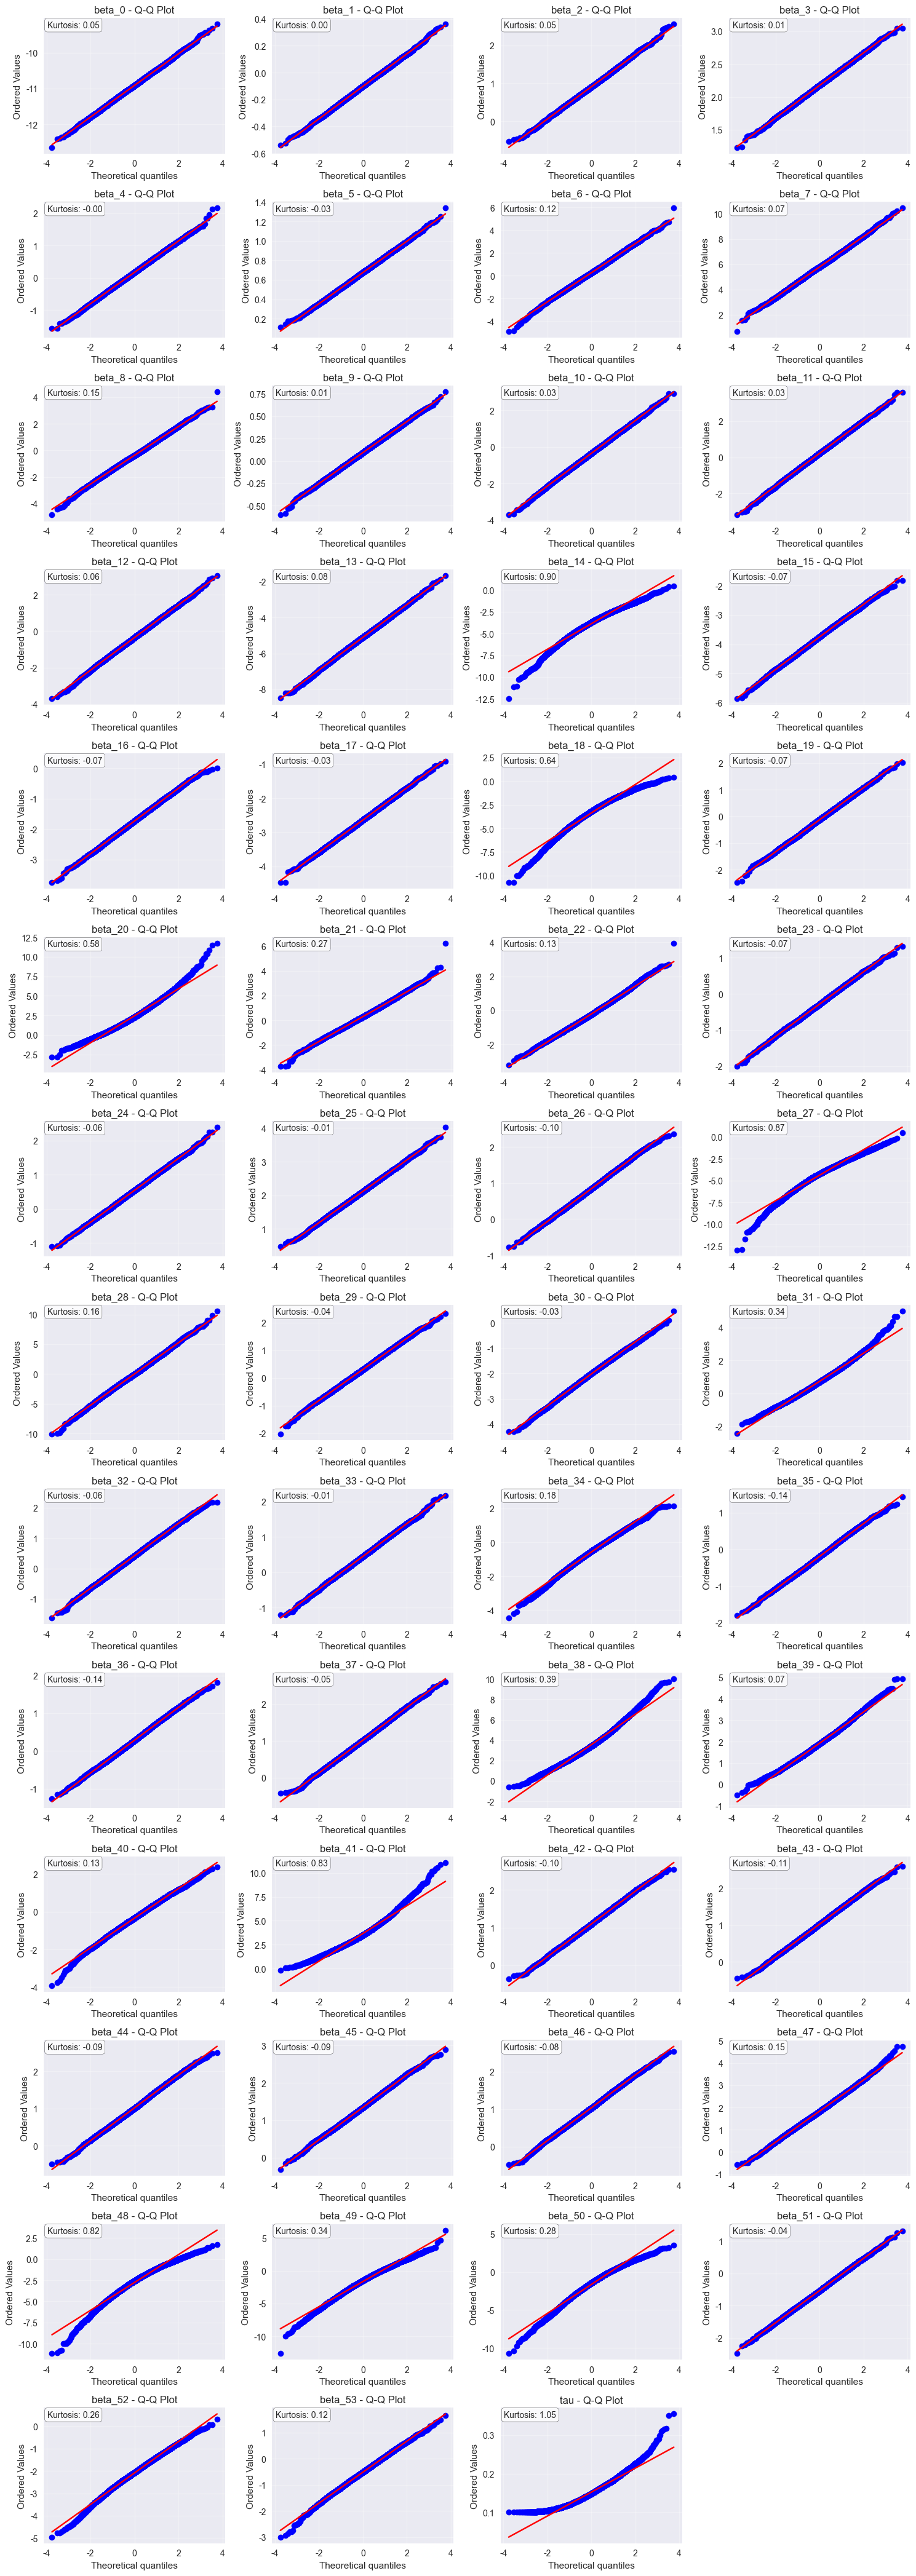

In [6]:
def plot_qq_plots(samples, n_cols=4):
    """Q-Qプロットで尾部の重さを確認"""
    n_params = samples.shape[1]
    n_rows = (n_params + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 3*n_rows))
    if n_rows == 1:
        axes = axes.reshape(1, -1)
    
    param_names = [f'beta_{i}' for i in range(n_params-1)] + ['tau']
    
    for i in range(n_params):
        row = i // n_cols
        col = i % n_cols
        ax = axes[row, col]
        
        # Q-Qプロット
        stats.probplot(samples[:, i], dist="norm", plot=ax)
        
        # タイトルとグリッド
        ax.set_title(f'{param_names[i]} - Q-Q Plot')
        ax.grid(True, alpha=0.3)
        
        # 尾部の重さの指標を計算
        kurtosis = stats.kurtosis(samples[:, i])
        ax.text(0.02, 0.98, f'Kurtosis: {kurtosis:.2f}', 
                transform=ax.transAxes, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    # 余分なサブプロットを非表示
    for i in range(n_params, n_rows * n_cols):
        row = i // n_cols
        col = i % n_cols
        axes[row, col].set_visible(False)
    
    plt.tight_layout()
    plt.show()

# Q-Qプロットを表示
if mcmc_samples is not None:
    plot_qq_plots(mcmc_samples)

## 5. パラメータ間の依存関係の分析

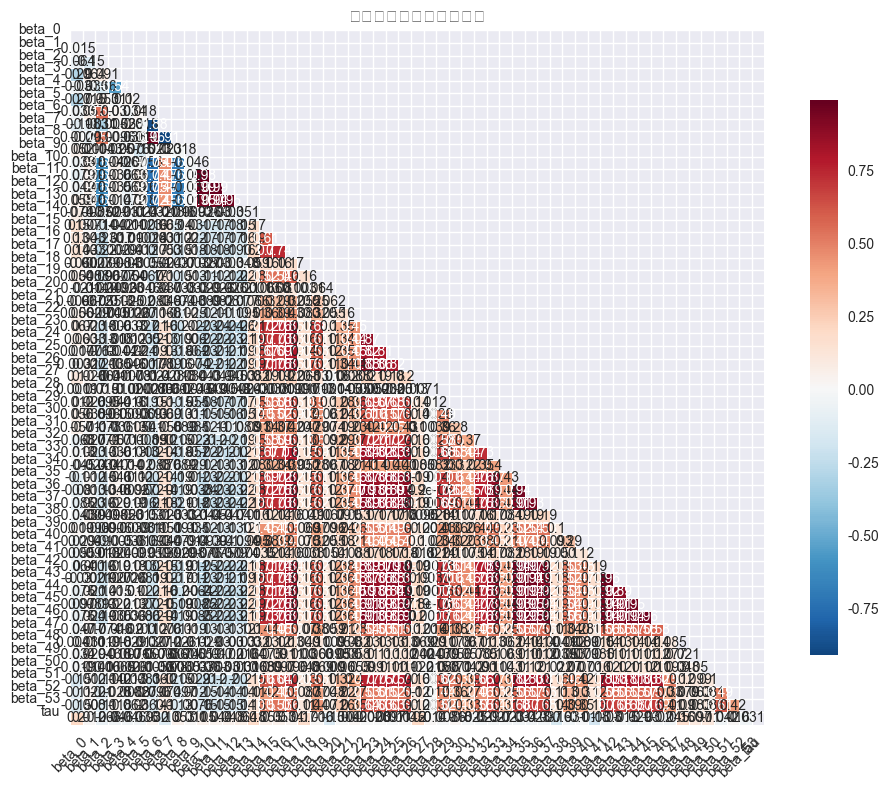

強い相関を持つパラメータペア:


Param1   Param2  Correlation
24   beta_10  beta_12     0.990518
26   beta_11  beta_12     0.988008
23   beta_10  beta_11     0.984198
357  beta_36  beta_42     0.965485
9     beta_6   beta_8     0.961777
..       ...      ...          ...
124  beta_19  beta_40     0.316192
340  beta_34  beta_53     0.310876
1     beta_2   beta_7    -0.305650
384  beta_39  beta_52     0.303221
273  beta_30  beta_34     0.302819

[429 rows x 3 columns]

<Figure size 1200x1000 with 0 Axes>

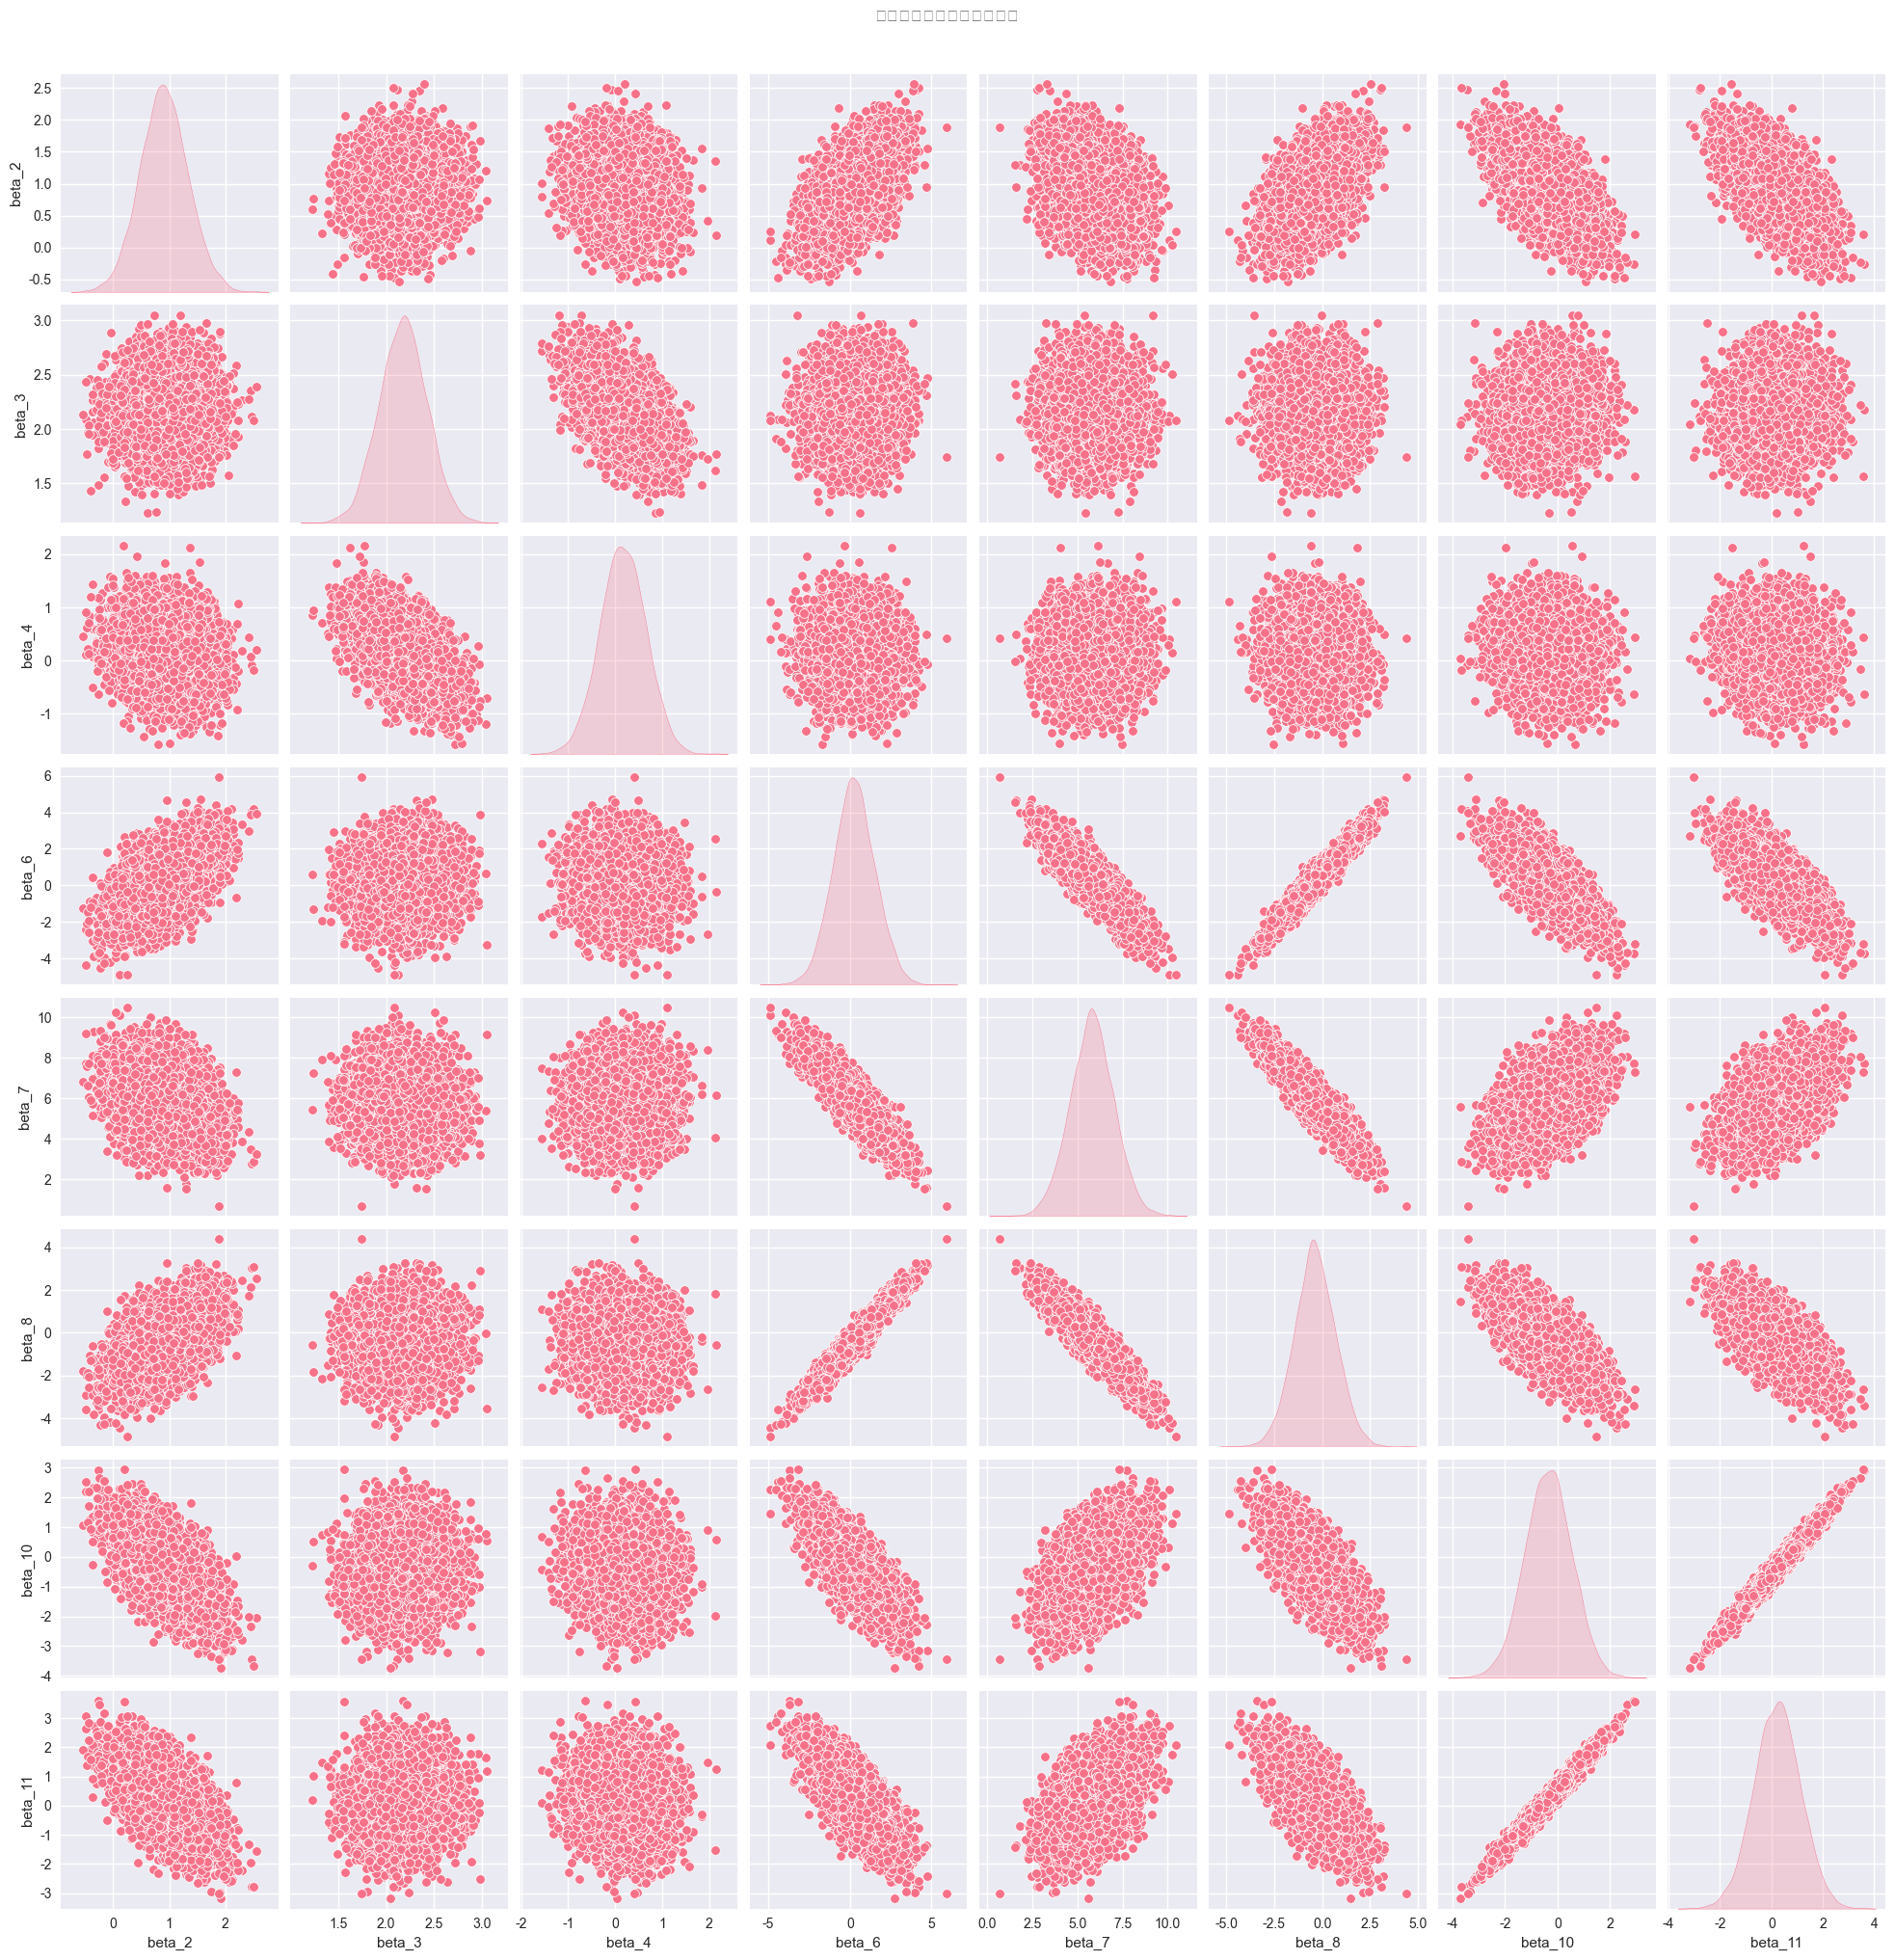

In [7]:
def analyze_dependencies(samples):
    """パラメータ間の依存関係を分析"""
    n_params = samples.shape[1]
    param_names = [f'beta_{i}' for i in range(n_params-1)] + ['tau']
    
    # 相関行列
    corr_matrix = np.corrcoef(samples.T)
    
    # 相関行列の可視化
    plt.figure(figsize=(10, 8))
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='RdBu_r', center=0,
                square=True, linewidths=0.5, cbar_kws={"shrink": .8})
    plt.title('パラメータ間の相関行列')
    plt.xticks(range(len(param_names)), param_names, rotation=45)
    plt.yticks(range(len(param_names)), param_names, rotation=0)
    plt.tight_layout()
    plt.show()
    
    # 強い相関を持つペアを特定
    strong_correlations = []
    for i in range(n_params):
        for j in range(i+1, n_params):
            corr_val = corr_matrix[i, j]
            if abs(corr_val) > 0.3:  # 閾値
                strong_correlations.append({
                    'Param1': param_names[i],
                    'Param2': param_names[j],
                    'Correlation': corr_val
                })
    
    if strong_correlations:
        print("強い相関を持つパラメータペア:")
        corr_df = pd.DataFrame(strong_correlations)
        display(corr_df.sort_values('Correlation', key=abs, ascending=False))
    else:
        print("強い相関を持つパラメータペアは見つかりませんでした")
    
    # 散布図行列（主要なパラメータのみ）
    # パラメータ数が多い場合は、相関の強いものや重要なもののみを表示
    if n_params <= 10:
        # すべてのパラメータを表示
        plot_params = range(n_params)
    else:
        # 相関の強いパラメータとtauを表示
        tau_idx = n_params - 1  # tauは最後のパラメータ
        high_corr_indices = []
        for i in range(n_params):
            for j in range(i+1, n_params):
                if abs(corr_matrix[i, j]) > 0.3:
                    high_corr_indices.extend([i, j])
        
        plot_params = list(set(high_corr_indices + [tau_idx]))[:8]  # 最大8個まで
    
    if len(plot_params) > 1:
        plot_samples = samples[:, plot_params]
        plot_names = [param_names[i] for i in plot_params]
        
        df_plot = pd.DataFrame(plot_samples, columns=plot_names)
        
        plt.figure(figsize=(12, 10))
        sns.pairplot(df_plot, diag_kind='kde')
        plt.suptitle('パラメータ間の散布図行列', y=1.02)
        plt.show()
    
    return corr_matrix

# 依存関係を分析
if mcmc_samples is not None:
    corr_matrix = analyze_dependencies(mcmc_samples)

## 6. 正規分布近似の誤差の定量化

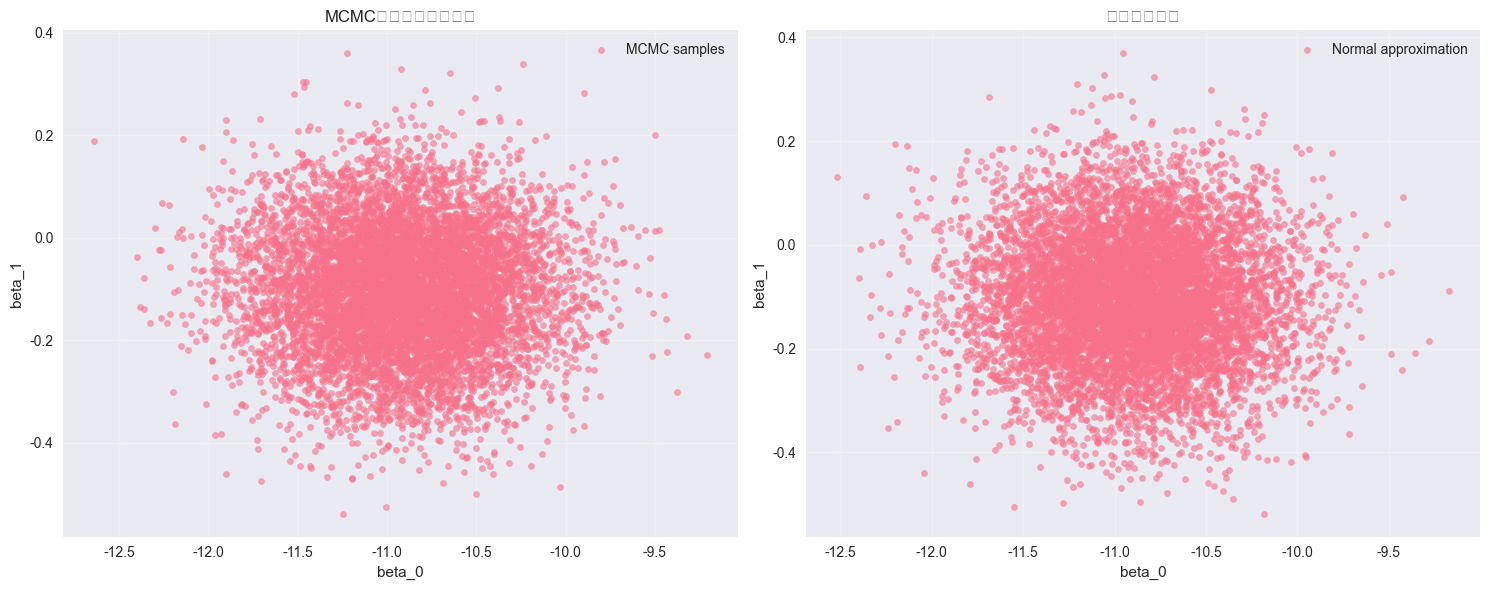

正規分布近似の誤差:


Parameter  KL_Divergence       MAE  Max_Error
0     beta_0       0.000812  0.008262   0.036946
1     beta_1       0.000766  0.023718   0.121486
2     beta_2       0.001060  0.007609   0.028024
3     beta_3       0.000747  0.012767   0.048687
4     beta_4       0.000607  0.005074   0.032490
5     beta_5       0.000610  0.017740   0.090427
6     beta_6       0.000880  0.002385   0.015365
7     beta_7       0.000999  0.003139   0.015563
8     beta_8       0.001245  0.003765   0.024178
9     beta_9       0.000449  0.012236   0.093557
10   beta_10       0.000489  0.002672   0.013355
11   beta_11       0.000443  0.002569   0.015271
12   beta_12       0.000672  0.003187   0.014081
13   beta_13       0.000705  0.002918   0.012689
14   beta_14       0.033867  0.012372   0.048933
15   beta_15       0.001148  0.009057   0.038440
16   beta_16       0.000970  0.005792   0.019032
17   beta_17       0.000516  0.005998   0.027974
18   beta_18       0.034389  0.013904   0.044609
19   beta_19       0.001039  0.006755   0.036875
20   beta_20       0.022640  0.008979   0.030691
21   beta_21       0.001930  0.003362   0.015685
22   beta_22       0.003222  0.006747   0.035188
23   beta_23       0.001113  0.010027   0.044727
24   beta_24       0.000725  0.007839   0.034891
25   beta_25       0.000720  0.006122   0.025142
26   beta_26       0.000918  0.008322   0.029494
27   beta_27       0.027285  0.011742   0.049453
28   beta_28       0.001182  0.001644   0.007485
29   beta_29       0.000630  0.005726   0.026935
30   beta_30       0.001675  0.008427   0.029098
31   beta_31       0.008185  0.008483   0.029870
32   beta_32       0.000862  0.006569   0.027424
33   beta_33       0.000946  0.008651   0.034080
34   beta_34       0.006538  0.010221   0.036405
35   beta_35       0.001277  0.011800   0.049315
36   beta_36       0.001193  0.011874   0.044863
37   beta_37       0.000984  0.006791   0.031829
38   beta_38       0.021545  0.012485   0.036134
39   beta_39       0.005995  0.010687   0.034952
40   beta_40       0.002901  0.006037   0.019882
41   beta_41       0.036839  0.015324   0.055334
42   beta_42       0.001295  0.009153   0.046084
43   beta_43       0.001043  0.009941   0.052786
44   beta_44       0.001542  0.012678   0.060731
45   beta_45       0.001243  0.009386   0.033177
46   beta_46       0.001211  0.011048   0.058099
47   beta_47       0.001154  0.004539   0.025348
48   beta_48       0.035935  0.012960   0.043194
49   beta_49       0.015622  0.006000   0.027471
50   beta_50       0.027279  0.010809   0.037526
51   beta_51       0.000548  0.006589   0.036659
52   beta_52       0.006348  0.010500   0.039224
53   beta_53       0.001636  0.005165   0.031966
54       tau       0.071234  0.679890   3.194520


誤差の要約:
平均KLダイバージェンス: 0.007233
最大KLダイバージェンス: 0.071234
平均MAE: 0.020699
最大MAE: 0.679890


In [8]:
def quantify_normal_approximation_error(samples, true_mu, true_A):
    """正規分布近似の誤差を定量化"""
    n_params = samples.shape[1]
    param_names = [f'beta_{i}' for i in range(n_params-1)] + ['tau']
    
    # 1. 各パラメータの正規分布近似誤差
    marginal_errors = []
    
    for i in range(n_params):
        data = samples[:, i]
        
        # 正規分布のパラメータ
        mu_norm = np.mean(data)
        std_norm = np.std(data)
        
        # カーネル密度推定
        kde = stats.gaussian_kde(data)
        x_range = np.linspace(data.min(), data.max(), 200)
        
        # 真の密度と正規分布密度
        true_density = kde(x_range)
        normal_density = norm.pdf(x_range, mu_norm, std_norm)
        
        # KLダイバージェンス（離散版）
        # ゼロ除算を避けるため、小さな値を追加
        eps = 1e-10
        true_density = np.clip(true_density, eps, None)
        normal_density = np.clip(normal_density, eps, None)
        
        kl_div = np.sum(true_density * np.log(true_density / normal_density)) * (x_range[1] - x_range[0])
        
        # 平均絶対誤差
        mae = np.mean(np.abs(true_density - normal_density))
        
        # 最大誤差
        max_error = np.max(np.abs(true_density - normal_density))
        
        marginal_errors.append({
            'Parameter': param_names[i],
            'KL_Divergence': kl_div,
            'MAE': mae,
            'Max_Error': max_error
        })
    
    # 2. 多変量正規分布近似の誤差
    # サンプルから計算した多変量正規分布
    sample_mu = np.mean(samples, axis=0)
    sample_cov = np.cov(samples.T)
    
    # 正規分布からのサンプリング
    n_samples = samples.shape[0]
    normal_samples = np.random.multivariate_normal(sample_mu, sample_cov, n_samples)
    
    # 2次元の可視化（最初の2つのパラメータ）
    if n_params >= 2:
        fig, axes = plt.subplots(1, 2, figsize=(15, 6))
        
        # 元のサンプル
        axes[0].scatter(samples[:, 0], samples[:, 1], alpha=0.6, s=20, label='MCMC samples')
        axes[0].set_xlabel(param_names[0])
        axes[0].set_ylabel(param_names[1])
        axes[0].set_title('MCMC事後分布サンプル')
        axes[0].legend()
        axes[0].grid(True, alpha=0.3)
        
        # 正規分布近似
        axes[1].scatter(normal_samples[:, 0], normal_samples[:, 1], alpha=0.6, s=20, label='Normal approximation')
        axes[1].set_xlabel(param_names[0])
        axes[1].set_ylabel(param_names[1])
        axes[1].set_title('正規分布近似')
        axes[1].legend()
        axes[1].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    # 3. 分布の形状の比較
    marginal_df = pd.DataFrame(marginal_errors)
    
    print("正規分布近似の誤差:")
    display(marginal_df.round(6))
    
    print("\n誤差の要約:")
    print(f"平均KLダイバージェンス: {marginal_df['KL_Divergence'].mean():.6f}")
    print(f"最大KLダイバージェンス: {marginal_df['KL_Divergence'].max():.6f}")
    print(f"平均MAE: {marginal_df['MAE'].mean():.6f}")
    print(f"最大MAE: {marginal_df['MAE'].max():.6f}")
    
    return marginal_df

# 正規分布近似の誤差を定量化
if mcmc_samples is not None:
    error_df = quantify_normal_approximation_error(mcmc_samples, true_mu, true_A)

## 7. 改善された評価指標の提案

In [9]:
def propose_improved_metrics(samples):
    """改善された評価指標を提案"""
    print("="*60)
    print("正規分布近似の妥当性評価結果と改善提案")
    print("="*60)
    
    # 基本統計量から判断
    skewness_vals = stats.skew(samples, axis=0)
    kurtosis_vals = stats.kurtosis(samples, axis=0)
    
    n_high_skew = np.sum(np.abs(skewness_vals) > 1.0)
    n_high_kurt = np.sum(kurtosis_vals > 3.0)
    
    print(f"\n1. 分布の形状分析:")
    print(f"   高い歪度を持つパラメータ数: {n_high_skew}/{samples.shape[1]}")
    print(f"   高い尖度を持つパラメータ数: {n_high_kurt}/{samples.shape[1]}")
    
    # 正規性検定
    shapiro_p_vals = []
    for i in range(samples.shape[1]):
        _, p_val = shapiro(samples[:, i])
        shapiro_p_vals.append(p_val)
    
    n_non_normal = np.sum(np.array(shapiro_p_vals) < 0.05)
    print(f"   正規分布と有意に異なるパラメータ数: {n_non_normal}/{samples.shape[1]}")
    
    # 推奨事項
    print(f"\n2. 推奨される評価指標:")
    
    if n_high_skew > samples.shape[1] * 0.3 or n_high_kurt > samples.shape[1] * 0.3:
        print("   ⚠️  多くのパラメータで非対称性/重い尾部が検出されました")
        print("   → 正規分布近似は不適切です")
        print("   → 推奨指標: MMD, Wasserstein距離, KSD")
    elif n_non_normal > samples.shape[1] * 0.5:
        print("   ⚠️  多くのパラメータで正規性が棄却されました")
        print("   → 正規分布近似は限定的に有効です")
        print("   → 推奨指標: KLダイバージェンス + MMD")
    else:
        print("   ✅ 正規分布近似は比較的妥当です")
        print("   → 推奨指標: KLダイバージェンス")
    
    print(f"\n3. 具体的な改善提案:")
    print("   a) 複数の距離尺度を併用する")
    print("   b) パラメータごとに個別評価を行う")
    print("   c) 分布の形状に応じて適応的に指標を選択する")
    print("   d) 解釈可能性を重視した評価を行う")
    
    # 実装例の提示
    print(f"\n4. 実装例:")
    print("   ```python")
    print("   def adaptive_evaluation(svgd_particles, mcmc_samples):")
    print("       # 分布の形状を事前に確認")
    print("       skewness = stats.skew(mcmc_samples, axis=0)")
    print("       kurtosis = stats.kurtosis(mcmc_samples, axis=0)")
    print("       ")
    print("       # 形状に応じて指標を選択")
    print("       if np.any(np.abs(skewness) > 1.0) or np.any(kurtosis > 3.0):")
    print("           return mmd_distance(svgd_particles, mcmc_samples)")
    print("       else:")
    print("           return kl_divergence(svgd_particles, mcmc_mean, mcmc_cov)")
    print("   ```")
    
    print("="*60)

# 改善提案を表示
if mcmc_samples is not None:
    propose_improved_metrics(mcmc_samples)

正規分布近似の妥当性評価結果と改善提案

1. 分布の形状分析:
   高い歪度を持つパラメータ数: 0/55
   高い尖度を持つパラメータ数: 0/55
   正規分布と有意に異なるパラメータ数: 23/55

2. 推奨される評価指標:
   ✅ 正規分布近似は比較的妥当です
   → 推奨指標: KLダイバージェンス

3. 具体的な改善提案:
   a) 複数の距離尺度を併用する
   b) パラメータごとに個別評価を行う
   c) 分布の形状に応じて適応的に指標を選択する
   d) 解釈可能性を重視した評価を行う

4. 実装例:
   ```python
   def adaptive_evaluation(svgd_particles, mcmc_samples):
       # 分布の形状を事前に確認
       skewness = stats.skew(mcmc_samples, axis=0)
       kurtosis = stats.kurtosis(mcmc_samples, axis=0)
       
       # 形状に応じて指標を選択
       if np.any(np.abs(skewness) > 1.0) or np.any(kurtosis > 3.0):
           return mmd_distance(svgd_particles, mcmc_samples)
       else:
           return kl_divergence(svgd_particles, mcmc_mean, mcmc_cov)
   ```


## 8. まとめと結論

この分析により、階層的ベイズロジスティック回帰モデルのMCMC事後分布の形状を詳しく理解し、
正規分布近似の妥当性を評価することができました。

### 主な発見:
1. **分布の形状**: 各パラメータの分布形状を可視化し、対称性や多峰性を確認
2. **尾部の重さ**: Q-Qプロットにより正規分布からの逸脱を確認
3. **パラメータ間の依存関係**: 相関構造と非線形依存関係を分析
4. **近似誤差の定量化**: 正規分布近似による誤差を数値的に評価

### 次のステップ:
1. この分析結果に基づいて、適切な評価指標を選択する
2. SVGDの収束性評価に、より適切な距離尺度を使用する
3. 必要に応じて、分布の形状を考慮した新しい評価指標を開発する